In [1]:
from libraries.db import DatabaseProxy
from bertopic import BERTopic
import dotenv
from bertopic.representation import OpenAI, KeyBERTInspired
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# disable deprecated warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
db = DatabaseProxy(reset=True, database="eda")
dotenv.load_dotenv(".envrc")

True

In [3]:
df = pd.read_csv("input/qa-pairs.csv", encoding="latin-1")
db.insert_from_dataframe(df, col_questions="question", col_answers="answer")

# Basic Statistics

In [4]:
df.head()

question  \
0  Checking the financial stability of our suppli...   
1  How many candidates do you have in your database?   
2  How do you select which candidates are placed ...   
3  How often do you review and refresh your datab...   
4  What type of background and drug testing do yo...   

                                              answer  \
0  Our fiscal year begins in January and ends in ...   
1  As of today, 4/25/2023, we have the following:...   
2  Our specialized role known as the client speci...   
3  Our sourcing platform is updated throughout th...   
4  AccuSource is our service provider for backgro...   

   partners_personnel_selected  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

Number of questions

In [5]:
df.shape

(168, 3)

Question length (character and word count)

In [6]:
df["question_length"] = df["question"].apply(len)
df["question_wordcount"] = df["question"].apply(lambda x: len(x.split(" ")))

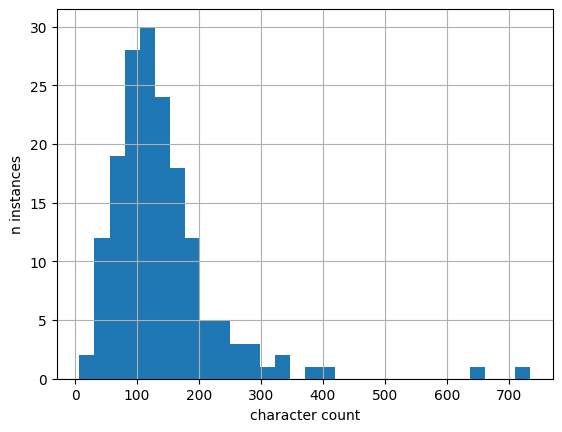

count    168.000000
mean     140.869048
std       91.372539
min        7.000000
25%       91.500000
50%      123.000000
75%      163.750000
max      735.000000
Name: question_length, dtype: float64

In [7]:
df["question_length"].hist(bins=30)
plt.xlabel("character count")
plt.ylabel("n instances")
plt.show()
df["question_length"].describe()

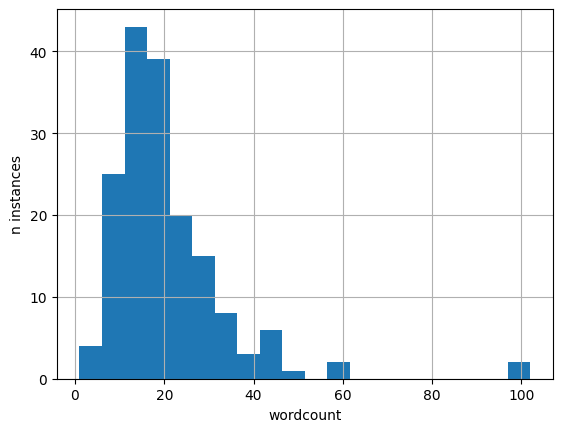

count    168.000000
mean      21.059524
std       13.481725
min        1.000000
25%       14.000000
50%       18.000000
75%       25.000000
max      102.000000
Name: question_wordcount, dtype: float64

In [8]:
df["question_wordcount"].hist(bins=20)
plt.xlabel("wordcount")
plt.ylabel("n instances")
plt.show()
df["question_wordcount"].describe()

Bundled question distribution

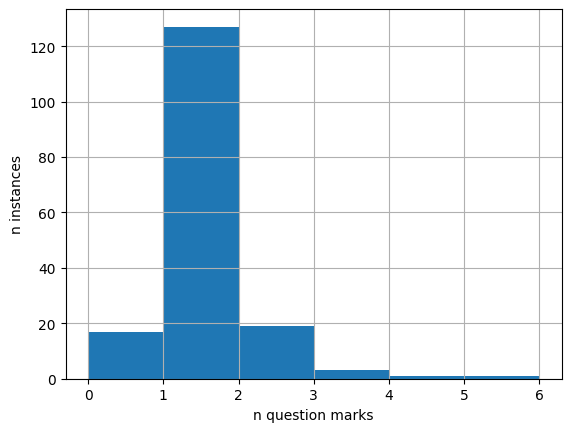

count    168.000000
mean       1.095238
std        0.694185
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: n_bundled_questions, dtype: float64

In [9]:
df["n_bundled_questions"] = df["question"].apply(lambda x: x.count("?"))
df["n_bundled_questions"].hist(bins=6)
plt.xlabel("n question marks")
plt.ylabel("n instances")
plt.show()
df["n_bundled_questions"].describe()

# Named Entity Recognizer

In [25]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [35]:
ents = []
for i, row in df.iterrows():
    question = row["question"]
    doc = nlp(question)
    ents.append([ent.lemma_.lower() for ent in doc.ents])
    if i % 16 == 0:
        displacy.render(doc, style="ent", jupyter=True)

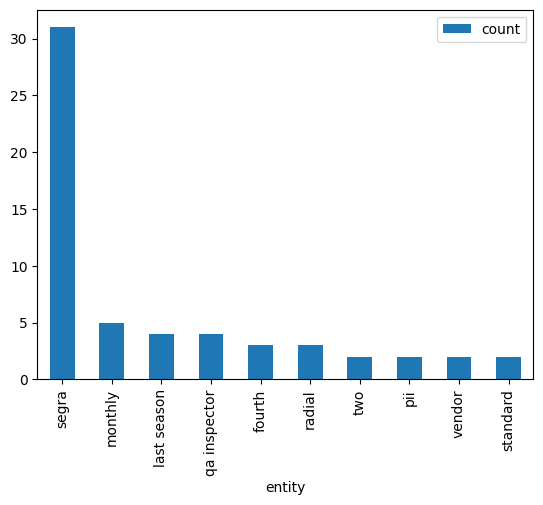

In [36]:
#bar chart of most common ent

from collections import Counter
from itertools import chain

ents = list(chain.from_iterable(ents))
ent_counts = Counter(ents)
ent_counts.most_common(10)

ent_counts_df = pd.DataFrame(ent_counts.most_common(10), columns=["entity", "count"])
ent_counts_df.plot.bar(x="entity", y="count")
plt.show()

# Word Frequency Analysis

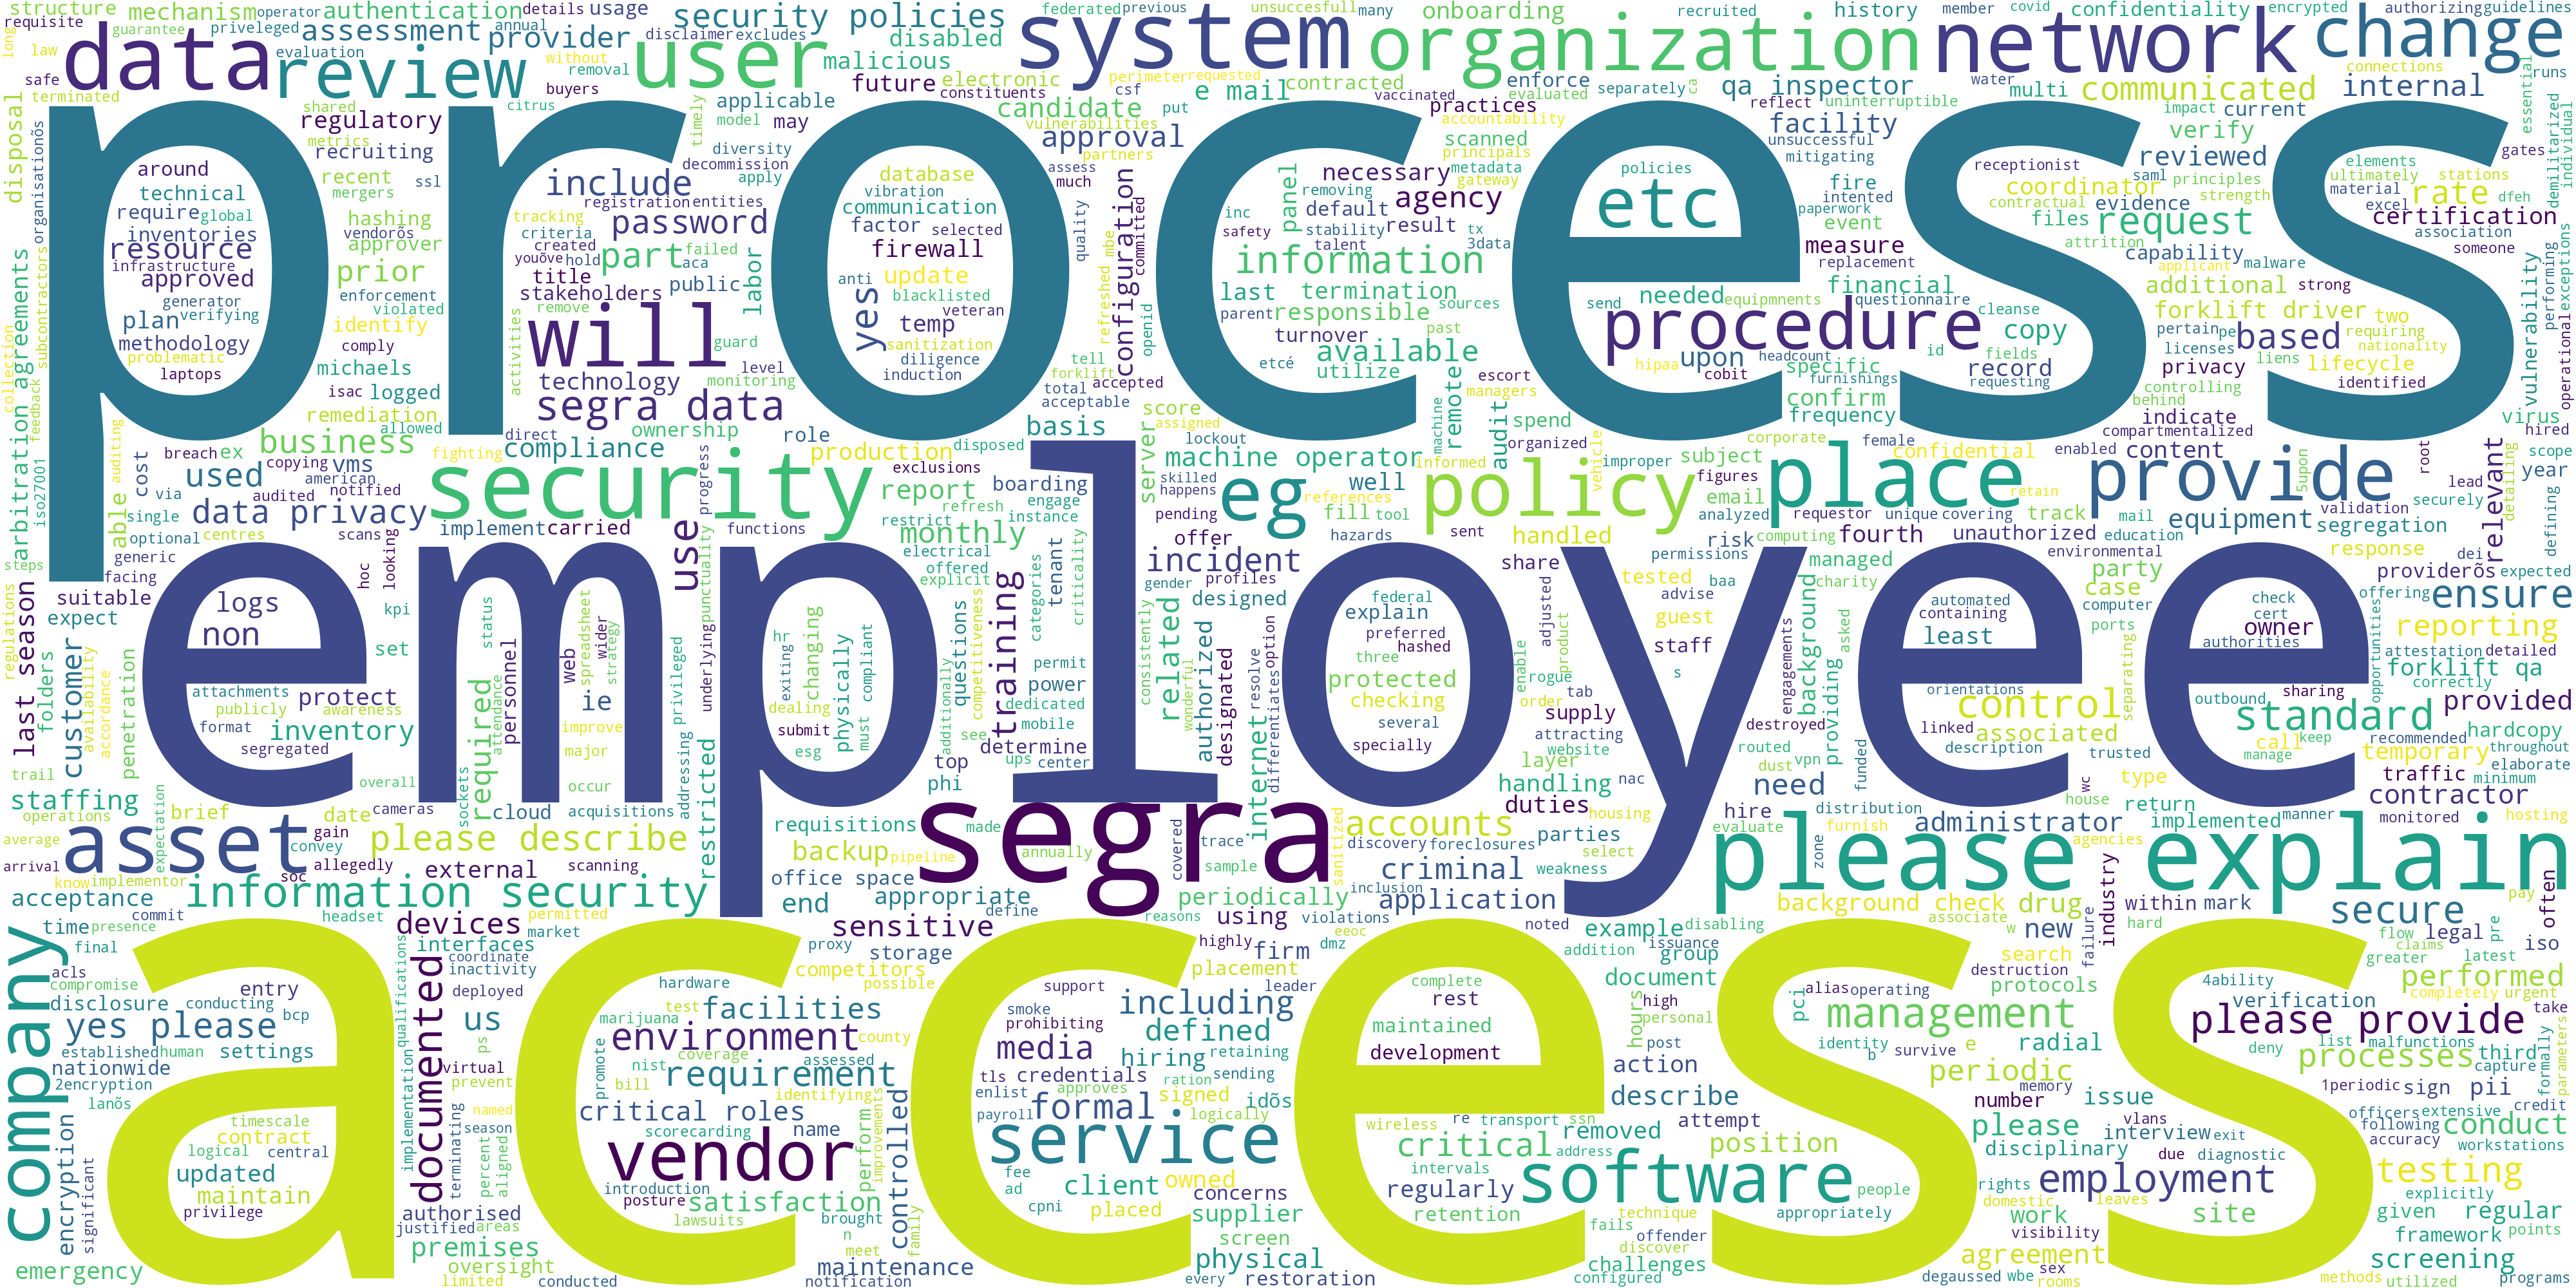

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ",".join(list(df_lda["question_processed"].values))
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    width=4000,
    height=2000,
    max_words=5000,
    contour_width=3,
    contour_color="steelblue",
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Topic Modeling

Uses LDA according to the following article: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Clean data

In [12]:
df_lda = pd.DataFrame(df[["question", "answer"]])

In [13]:
# Load the regular expression library
import re

# Remove punctuation
df_lda["question_processed"] = df_lda["question"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
# Convert the titles to lowercase
df_lda["question_processed"] = df_lda["question_processed"].map(lambda x: x.lower())
# remove extraneous whitespace
df_lda["question_processed"] = df_lda["question_processed"].str.strip()
# Print out the first rows of papers
df_lda["question_processed"].head()

0    checking the financial stability of our suppli...
1     how many candidates do you have in your database
2    how do you select which candidates are placed ...
3    how often do you review and refresh your datab...
4    what type of background and drug testing do yo...
Name: question_processed, dtype: object

Prepare data for LDA analysis

In [15]:
from gensim.utils import simple_preprocess

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use"])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield (simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


data = df_lda["question_processed"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['checking', 'financial', 'stability', 'suppliers', 'part', 'due', 'diligence', 'process', 'support', 'us', 'please', 'tell', 'us', 'company', 'financial', 'year', 'runs']


In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1)]


LDA model training

In [17]:
import gensim
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus, id2word=id2word, num_topics=num_topics
)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"access" + 0.019*"data" + 0.018*"provide" + 0.017*"segra" + '
  '0.011*"employees" + 0.009*"please" + 0.009*"system" + 0.007*"organization" '
  '+ 0.007*"critical" + 0.007*"facilities"'),
 (1,
  '0.017*"please" + 0.016*"segra" + 0.012*"security" + 0.011*"critical" + '
  '0.011*"testing" + 0.011*"end" + 0.010*"process" + 0.010*"information" + '
  '0.009*"changes" + 0.009*"system"'),
 (2,
  '0.023*"security" + 0.018*"please" + 0.016*"process" + 0.014*"yes" + '
  '0.010*"network" + 0.010*"agreements" + 0.009*"segra" + 0.009*"eg" + '
  '0.008*"information" + 0.008*"background"'),
 (3,
  '0.019*"explain" + 0.019*"please" + 0.017*"segra" + 0.014*"standards" + '
  '0.014*"process" + 0.014*"criminal" + 0.010*"based" + 0.010*"requirements" + '
  '0.010*"ensure" + 0.009*"secure"'),
 (4,
  '0.024*"segra" + 0.015*"access" + 0.012*"inventory" + 0.012*"employees" + '
  '0.012*"network" + 0.010*"internal" + 0.009*"place" + 0.009*"organization" + '
  '0.009*"devices" + 0.008*"need"'),
 (

Analyzing LDA results

In [18]:
import pyLDAvis.gensim
import pickle
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join("./output/ldavis_prepared_" + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(
    LDAvis_prepared, "./output/ldavis_prepared_" + str(num_topics) + ".html"
)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.129732  0.033069       1        1  15.453154
8     -0.010350 -0.026108       2        1  13.110906
7      0.086764  0.054626       3        1  12.720126
1     -0.008146 -0.126006       4        1  11.444987
5     -0.127798  0.079420       5        1  10.157968
3     -0.058452  0.013974       6        1  10.139965
6     -0.015593 -0.108736       7        1   8.549965
2     -0.020021  0.036537       8        1   7.097726
4      0.038703  0.005935       9        1   6.725422
9     -0.014841  0.037289      10        1   4.599781, topic_info=         Term       Freq      Total Category  logprob  loglift
180    vendor   6.000000   6.000000  Default  30.0000  30.0000
7     process  19.000000  19.000000  Default  29.0000  29.0000
420  software   8.000000   8.000000  Default  28.0000  28.0000
116     segra  24.000000  24.000000  Default  27.0000  27.0000
234  security  26.000000  26.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
555  facility   0.571650   3.420079  Topic10  -5.1463   1.2903
669     party   0.571646   2.678788  Topic10  -5.1463   1.5346
24      place   0.571645  12.578400  Topic10  -5.1463  -0.0121
566   content   0.571644   1.908070  Topic10  -5.1463   1.8738
252      user   0.571643   6.204939  Topic10  -5.1463   0.6946

[622 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
192       2  0.347915      able
192       4  0.347915      able
453       6  0.710530  accepted
211       1  0.352107    access
211       2  0.132040    access
...     ...       ...       ...
82        4  0.090739       yes
82        6  0.090739       yes
82        7  0.090739       yes
82        8  0.181478       yes
82       10  0.090739       yes

[848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 2, 6, 4, 7, 3, 5, 10])

# Vocabulary Size

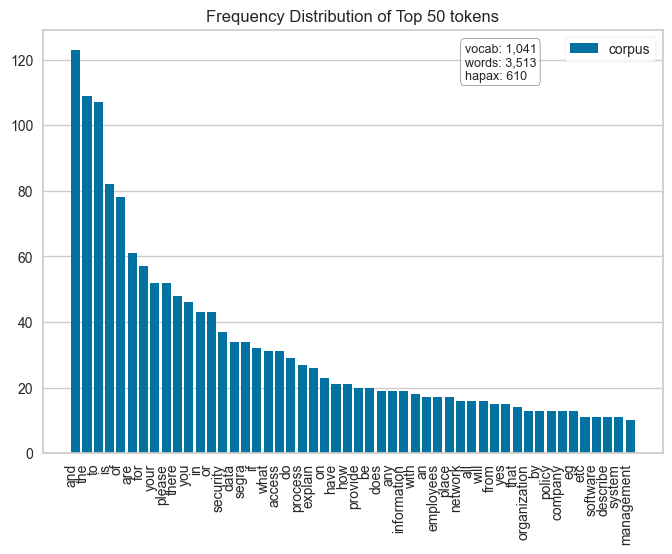

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [ ]:
#Analyze the size of your vocabulary. This can be important for selecting appropriate vectorization techniques.
#Consider the distribution of rare words and whether they should be handled specially during vectorization.

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(df_lda["question_processed"])

features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient="v")
visualizer.fit(docs)
visualizer.show()

# bertopic

In [19]:
questions = [q.text for q in db.get_questions()]

In [20]:
questions[:5]

['Checking the financial stability of our suppliers is part of our due diligence process. To support us in doing this, please tell us when your company financial year runs to and from.',
 'How many candidates do you have in your database?',
 'How do you select which candidates are placed where?  For instance, if two buyers are looking for the same candidate, how do you ultimately determine which company to place that employee with?',
 'How often do you review and refresh your database of candidates?',
 'What type of background and drug testing do you conduct?  How extensive are they? Who is your service provider for background checking?']

In [21]:
# Fine-tune topic representations with GPT
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(questions)

/Users/kalebsmith/ownCloud/school/cs-482/Partners-Personnel-Capstone-Project/.venv/lib/python3.11/site-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


In [22]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0     -1     90       -1_procedures_documented_incidents_reporting   
1      0     22                   0_staffing_forklift_hiring_roles   
2      1     20              1_providers_facilities_services_segra   
3      2     20  2_privacy_confidentialitynondisclosure_complia...   
4      3     16  3_permissions_privileged_privilege_someonesecu...   

                                      Representation  \
0  [procedures, documented, incidents, reporting,...   
1  [staffing, forklift, hiring, roles, qa, placem...   
2  [providers, facilities, services, segra, proto...   
3  [privacy, confidentialitynondisclosure, compli...   
4  [permissions, privileged, privilege, someonese...   

                                 Representative_Docs  
0  [Are there formal procedures for reporting inc...  
1  [If you were a provider of ours last season wh...  
2  [Is the network used for providing service to ...  
3  [Is  a regulatory data privacy and data securi...  
4  [Are critical system files and folders protect...

In [23]:
for _, row in topic_model.get_topic_info().iterrows():
    print(row["Name"], row["Count"])
    for doc in row["Representative_Docs"]:
        print(f"\t-{doc.strip()}")
    print()

-1_procedures_documented_incidents_reporting 90
	-Are there formal procedures for reporting incidents like:
- Security Incidents
- Security Weakness
- Software Malfunctions
- Malicious Software etc
to Segra? i.e.
Segra should be informed of all security incidents at the Vendor premises. Please provide a copy of your incident response plan.
	-What is your process for auditing employee onboarding paperwork to ensure arbitration agreements are signed?
Where do you maintain the arbitration agreements and for how long? 
What is the process for requesting the documents if/when needed?
	-Is there a process in place to ensure all employees and external users return the organization's assets on termination of their employment, contract or agreement?

0_staffing_forklift_hiring_roles 22
	-If you were a provider of ours last season what was your turnover rate?  If you did not provide labor to us last season what is your average turnover rate?
	-If you were a provider of ours last season what was 